## Import libraries

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import monai
from monai.data import Dataset, ArrayDataset, DataLoader
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd, CropForegroundd, ScaleIntensityRangePercentilesd, RandFlipd, Resized

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
os.getcwd()

'/home/infres/xchen-21/IMA206_project'

In [3]:
# reload if update
import importlib
import util
importlib.reload(util)

<module 'util' from '/home/infres/xchen-21/IMA206_project/util.py'>

## Load data and visualize

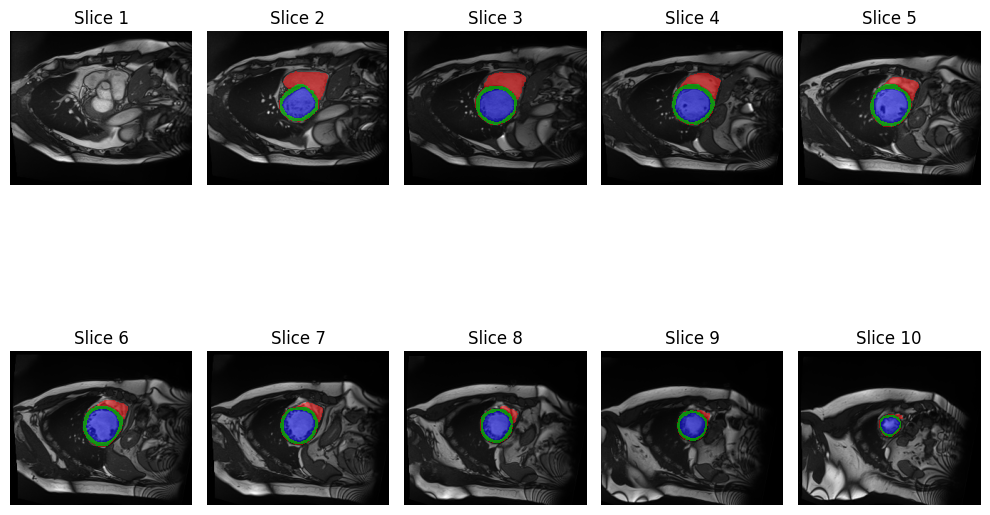

In [4]:
# visualize raw example before preprocessing
file_dict1 = util.load_file_dict(1,'ED')
data_dict1 = util.load_data_dict(1,'ED')
util.visualize_3D(data_dict1)

In [5]:
train_dicts = []
for patient_id in range(1,101):
    train_dicts.append(util.load_file_dict(patient_id,'ED'))
    train_dicts.append(util.load_file_dict(patient_id,'ES'))

test_dicts = []
for patient_id in range(101,151):
    test_dicts.append(util.load_file_dict(patient_id,'ED'))
    test_dicts.append(util.load_file_dict(patient_id,'ES'))

len(train_dicts), len(test_dicts)

(200, 100)

In [6]:
train_dicts[0]

{'image': '/home/infres/xchen-21/IMA206_project/database/training/patient001/patient001_frame01.nii.gz',
 'label': '/home/infres/xchen-21/IMA206_project/database/training/patient001/patient001_frame01_gt.nii.gz'}

## Preprocessing

In [7]:
class CropForegroundSquared:
    '''
    crop bounding box with margin
    '''
    def __init__(self, keys, source_key, min_margin):
        self.keys = keys
        self.source_key = source_key
        self.min_margin = min_margin
    
    def __call__(self, img_dict):
        mask = img_dict[self.source_key] > 0
        idx = torch.argwhere(mask)
        mins,_ = idx.min(dim=0)
        maxs,_ = idx.max(dim=0)
        _, a, b, _ = maxs - mins
        z_s = mins[3]
        z_e = maxs[3]+1
        if a >= b:
            off = (a-b)//2
            x_s = mins[1]-self.min_margin
            x_e = maxs[1]+self.min_margin+1
            y_s = mins[2]-self.min_margin-off
            y_e = maxs[2]+self.min_margin+off+1
        else:
            off = (b-a)//2
            x_s = mins[1]-self.min_margin-off
            x_e = maxs[1]+self.min_margin+off+1
            y_s = mins[2]-self.min_margin
            y_e = maxs[2]+self.min_margin+1
        for k in self.keys:
            img_dict[k] = img_dict[k][:,x_s:x_e,y_s:y_e,z_s:z_e]
        return img_dict

### preprocessing for 2D segmentation

In [8]:
class To2DSlice:
    '''
    permute depth dimension to first channel
    return [image, label] of dimension (D,1,H,W)
    '''
    def __init__(self, keys):
        self.keys = keys
        
    def __call__(self, img_dict):
        ret = []
        for k in self.keys:
            ret.append(img_dict[k].permute(3,0,1,2))
        return ret

In [9]:
train_transforms = Compose(
    [LoadImaged(keys=["image", "label"]),
     EnsureChannelFirstd(keys=["image", "label"]),
     Orientationd(keys=["image", "label"], axcodes="RAS"),
     Spacingd(
        keys=["image", "label"],
        pixdim=[1.25, 1.25, 10],
        mode=("bilinear", "nearest")),
     CropForegroundSquared(keys=["image", "label"], source_key="label", min_margin=5),
     ScaleIntensityRangePercentilesd(
        keys=["image"],
        lower=5,
        upper=95,
        b_min=0.0,
        b_max=1.0,
        clip=True),
     Resized(
        keys=["image", "label"],
        spatial_size=(128,128,-1),
        mode=("trilinear", "nearest")),
     # RandFlipd(
     #    keys=["image", "label"],
     #    spatial_axis=[0],
     #    prob=0.2),
     # RandFlipd(
     #    keys=["image", "label"],
     #    spatial_axis=[1],
     #    prob=0.2),
     # RandFlipd(
     #    keys=["image", "label"],
     #    spatial_axis=[2],
     #    prob=0.2),
     To2DSlice(keys=["image", "label"])])

test_transforms = Compose(
    [LoadImaged(keys=["image", "label"]),
     EnsureChannelFirstd(keys=["image", "label"]),
     Orientationd(keys=["image", "label"], axcodes="RAS"),
     Spacingd(
        keys=["image", "label"],
        pixdim=[1.25, 1.25, 10],
        mode=("bilinear", "nearest")),
     CropForegroundSquared(keys=["image", "label"], source_key="label", min_margin=5),
     ScaleIntensityRangePercentilesd(
        keys=["image"],
        lower=5,
        upper=95,
        b_min=0.0,
        b_max=1.0,
        clip=True),
     Resized(
        keys=["image", "label"],
        spatial_size=(128,128,-1),
        mode=("trilinear", "nearest")),
     To2DSlice(keys=["image", "label"])])

In [10]:
train_data = []
for train_dict in tqdm(train_dicts, desc='preprocess train set'):
    train_data.append(train_transforms(train_dict))

test_data = []
for test_dict in tqdm(test_dicts, desc='preprocess test set'):
    test_data.append(test_transforms(test_dict))

preprocess test set: 100%|█████████████████████████████████| 100/100 [00:28<00:00,  3.51it/s]


In [11]:
train_X, train_Y = zip(*train_data)
test_X, test_Y = zip(*test_data)

In [12]:
train_X = torch.concatenate(train_X, dim=0)
train_Y = torch.concatenate(train_Y, dim=0)
test_X = torch.concatenate(test_X, dim=0)
test_Y = torch.concatenate(test_Y, dim=0)

In [13]:
train_X.shape, test_X.shape

(torch.Size([1665, 1, 128, 128]), torch.Size([857, 1, 128, 128]))

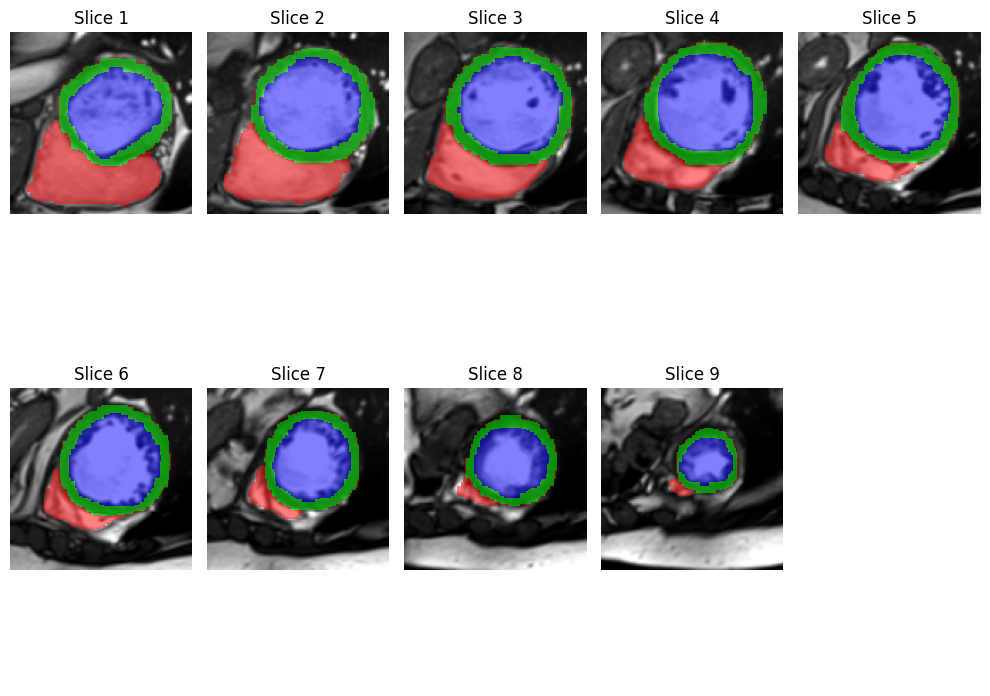

In [14]:
# visualize example after preprocessing
util.visualize_3D({"image": train_X[:9,0].permute(1,2,0),
                   "label": train_Y[:9,0].permute(1,2,0)})

## Prepare dataset and dataloader

In [43]:
TRAIN_RATIO = 0.7
BATCH_SIZE = 64
BATCH_SIZE_VAL = 64

In [16]:
# split train and validation
idx = np.arange(len(train_X))
np.random.shuffle(idx)

train_len = int(len(train_X)*TRAIN_RATIO)
train_X, val_X = train_X[idx[:train_len]], train_X[idx[train_len:]]
train_Y, val_Y = train_Y[idx[:train_len]], train_Y[idx[train_len:]]

In [17]:
train_set = ArrayDataset(img=train_X, seg=train_Y, img_transform=None) # TODO: data augmentation here!
val_set = ArrayDataset(img=val_X, seg=val_Y)
test_set = ArrayDataset(img=test_X, seg=test_Y)

In [90]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE_VAL)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE_VAL)

In [19]:
batch = next(iter(train_loader))
batch[0].shape, batch[1].shape

(torch.Size([64, 1, 128, 128]), torch.Size([64, 1, 128, 128]))

## Train a U-Net

In [20]:
from unet import UNet

In [50]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LR = 1e-2
EPOCH = 100
SAVE_UNET_PATH = 'saved_models/unet_0613.pt'

In [87]:
# define model, loss function and optimizer
model = UNet(n_channels=1, n_classes=4).to(DEVICE)
print(model)

# Compute both Dice loss and Cross Entropy Loss, and return the weighted sum of these two losses
loss_function = monai.losses.DiceCELoss(softmax=True, to_onehot_y=True,
                                        lambda_dice=1, lambda_ce=0.1)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [88]:
def compute_eval_loss(model, val_loader):
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_data in val_loader:
            input = batch_data[0]
            label = batch_data[1]

            outputs = model(input.to(DEVICE))
            loss = loss_function(outputs, label.to(DEVICE))

            # print(loss.item())
            epoch_val_loss += loss.item()

    return epoch_val_loss / len(val_loader)

In [89]:
 # train model
model.train()

training_losses = []
val_losses = []

min_val_loss = np.inf
best_epoch = 0

for epoch in range(EPOCH):
    epoch_loss = 0

    for batch_data in train_loader:
        input = batch_data[0].to(DEVICE)
        label = batch_data[1].to(DEVICE)

        optimizer.zero_grad()

        outputs = model(input)
        loss = loss_function(outputs, label)
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    training_loss = epoch_loss / len(train_loader)
    training_losses.append(training_loss)

    # compute loss on validation set
    val_loss = compute_eval_loss(model, val_loader)
    val_losses.append(val_loss)

    print(f'\nepoch {epoch}/{EPOCH} training loss: {training_loss} validation loss: {val_loss}')



    # if minimum validation loss, save model
    if val_loss < min_val_loss:
        torch.save(model.state_dict(), SAVE_UNET_PATH)
        print(f'minimum validation loss, current model weights saved at {SAVE_UNET_PATH}')
        min_val_loss = val_loss
        best_epoch = epoch
    else:
        print('no improvement on validation loss')



epoch 0/100 training loss: 0.5776538378313968 validation loss: 0.3940720222890377
minimum validation loss, current model weights saved at saved_models/unet_0613.pt

epoch 1/100 training loss: 0.30374813864105626 validation loss: 0.25335596315562725
minimum validation loss, current model weights saved at saved_models/unet_0613.pt

epoch 2/100 training loss: 0.235973795777873 validation loss: 0.20224531553685665
minimum validation loss, current model weights saved at saved_models/unet_0613.pt

epoch 3/100 training loss: 0.20193942597037867 validation loss: 0.18507822789251804
minimum validation loss, current model weights saved at saved_models/unet_0613.pt

epoch 4/100 training loss: 0.178960172753585 validation loss: 0.1669309176504612
minimum validation loss, current model weights saved at saved_models/unet_0613.pt

epoch 5/100 training loss: 0.16175080443683423 validation loss: 0.14979230053722858
minimum validation loss, current model weights saved at saved_models/unet_0613.pt

epoc

In [95]:
# load model from checkpoints
print(f'Best validation error {min_val_loss:.4f} is achieved at epoch{best_epoch}')
# SAVE_UNET_PATH = 'saved_models/unet_bbox_crop.pt'
state_dict = torch.load(SAVE_UNET_PATH)
model.load_state_dict(state_dict)
print(f'Weights loaded from {SAVE_UNET_PATH}')

Best validation error 0.0839 is achieved at epoch74
Weights loaded from saved_models/unet_0613.pt


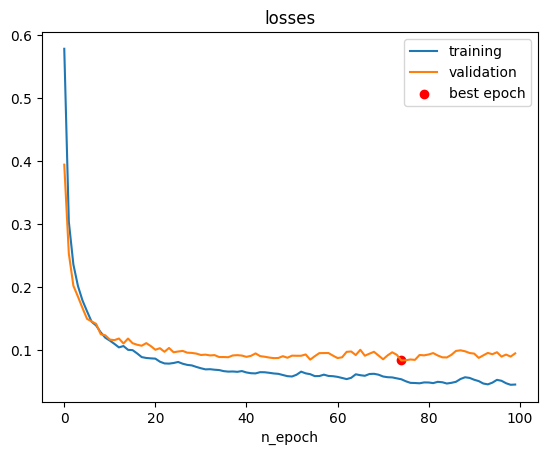

In [96]:
plt.plot(training_losses, label='training')
plt.plot(val_losses, label='validation')
plt.scatter([best_epoch], [val_losses[best_epoch]], label='best epoch', color='r')
plt.title('losses')
plt.xlabel('n_epoch')
# plt.savefig(os.path.join(base_path,'images/train_loss.png'))
plt.legend()
plt.show()

## Performance on test set

In [124]:
postprocess = monai.transforms.Compose([
    monai.transforms.AsDiscrete(argmax=True, to_onehot=4, dim=1),
    monai.transforms.KeepLargestConnectedComponent(applied_labels=(1, 2, 3), independent=False, connectivity=None)
    # TODO: more postprocess
])

model.eval()

dscs_list = []

dice_metric = monai.metrics.DiceMetric()
hd_metric = monai.metrics.HausdorffDistanceMetric()

for i, test_batch in enumerate(test_loader):
    test_input = test_batch[0]
    with torch.no_grad():
        outputs_test = model(test_input.to(DEVICE))

    outputs_test = postprocess(outputs_test) # (BS, 4, H, W) a 0-1 mask for 4 classes

    y_pred = outputs_test.cpu()
    y_gt = monai.networks.utils.one_hot(test_batch[1],dim=1,num_classes=4)

    dsc = dice_metric(y_pred[:, 1:, :, :], y_gt[:, 1:, :, :]) # exclude background (BS, 3)
    dscs_list.append(dsc)

    # hd = hd_metric(y_pred, y_gt)
    # hds[i] = np.nanmean(hd.numpy(),axis=0)

dscs = np.concatenate(dscs_list, axis=0)

In [125]:
dscs.shape

(857, 3)

In [128]:
# smallest DICE metrics - worst performance
row_sums = np.sum(dscs, axis=1)
sorted_indices = np.argsort(row_sums)
smallest_indices = sorted_indices[:10]
smallest_indices

array([785, 456, 481, 707, 682, 433, 673, 418, 547,  63])

## Evaluation (deprecate)

In [65]:
model.eval()
1

1

In [66]:
postprocess = monai.transforms.Compose([
    monai.transforms.AsDiscrete(argmax=True, to_onehot=4, dim=1),
    monai.transforms.KeepLargestConnectedComponent(applied_labels=(1, 2, 3), independent=False, connectivity=None)
    # TODO: more postprocess
])

ground truth


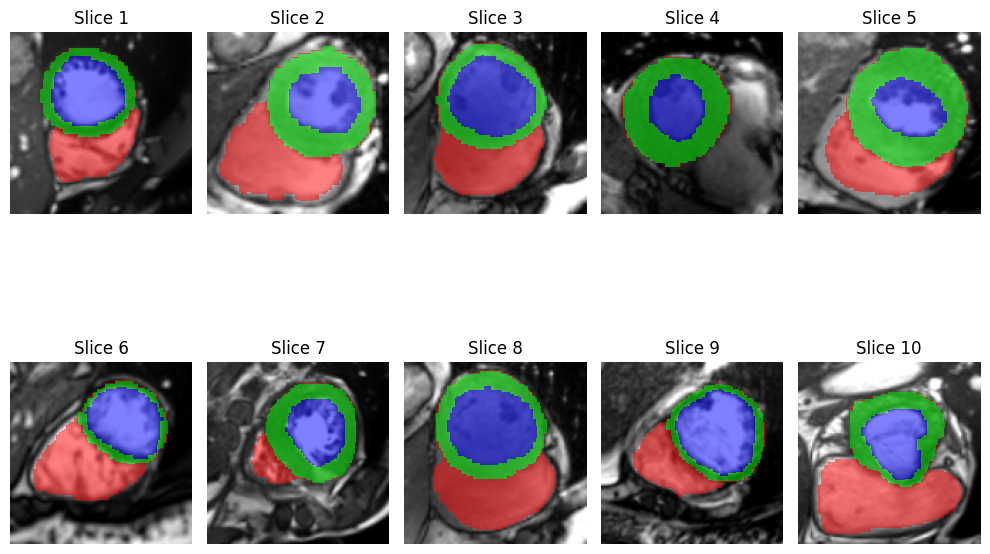

prediction


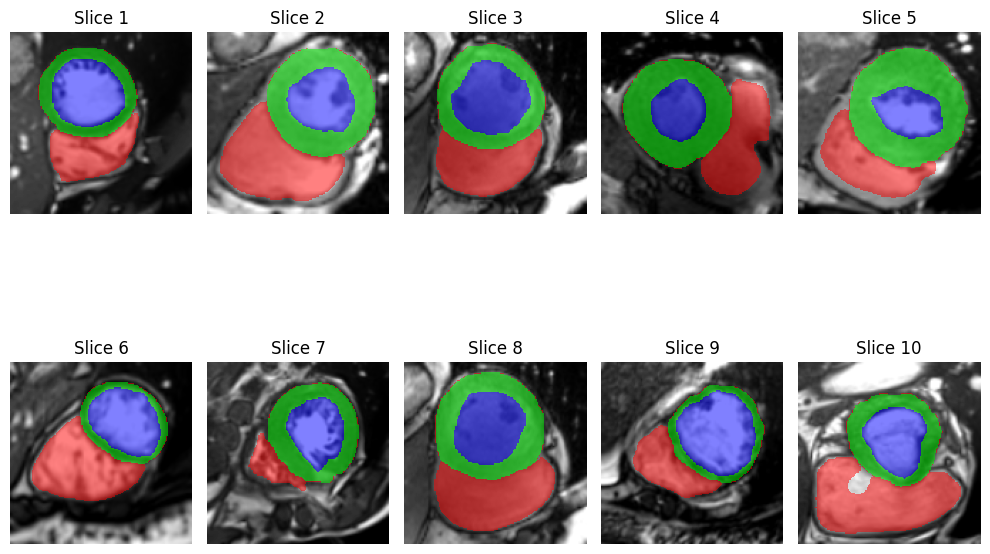

In [73]:
# visualize predicted and ground truth result on val set
val_batch = next(iter(val_loader))

val_input = val_batch[0]
with torch.no_grad():
    outputs_val = model(val_input.to(DEVICE))
outputs_val = postprocess(outputs_val)

label_pred = torch.argmax(outputs_val, dim=1).cpu()
label_gt = val_batch[1].squeeze()

print('ground truth')
util.visualize_3D({"image": val_input[:10,0].permute(1,2,0),
                   "label": label_gt[:10].permute(1,2,0)})

print('prediction')
util.visualize_3D({"image": val_input[:10,0].permute(1,2,0),
                   "label": label_pred[:10].permute(1,2,0)})

In [74]:
# evaluate metrics on val set
model.eval()

# store HD and DSC by class
hds = np.zeros((len(val_loader), 3))
dscs = np.zeros((len(val_loader), 3))

for i, val_batch in enumerate(val_loader):
    val_input = val_batch[0]
    with torch.no_grad():
        outputs_val = model(val_input.to(DEVICE))

    outputs_val = postprocess(outputs_val) # (BS, 4, H, W) a 0-1 mask for 4 classes

    y_pred = outputs_val.cpu()
    y_gt = monai.networks.utils.one_hot(val_batch[1],dim=1,num_classes=4)

    dice_metric = monai.metrics.DiceMetric()
    dsc = dice_metric(y_pred[:, 1:, :, :], y_gt[:, 1:, :, :]) # exclude background (BS, 3)

    hd_metric = monai.metrics.HausdorffDistanceMetric()
    hd = hd_metric(y_pred, y_gt)

    hds[i] = np.nanmean(hd.numpy(),axis=0)
    dscs[i] = np.nanmean(dsc.numpy(),axis=0)

# TODO: show avg by class
print(f'Average metrics over val set of three classes: DSC {dscs.mean(axis=0)}, HD {hds.mean(axis=0)}')

/home/infres/xchen-21/dream/diffusers/examples/dreambooth/.env/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:168: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/infres/xchen-21/dream/diffusers/examples/dreambooth/.env/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:170: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/infres/xchen-21/dream/diffusers/examples/dreambooth/.env/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:168: UserWarning: the ground truth of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/infres/xchen-21/dream/diffusers/examples/dreamb

Average metrics over val set of three classes: DSC [0.83834359 0.86215228 0.90642568], HD [inf inf inf]


In [83]:
hds

array([[        inf,  7.68422427,  7.56459193],
       [ 8.044864  ,  5.87376006,  5.24885981],
       [10.61284387,  5.54424618,  5.52745091],
       [14.73791801,  6.12188197,  5.40526977],
       [        inf, 12.70701125,         inf],
       [        inf,  8.78827845,  9.82222622],
       [17.6201304 ,  6.86856121,         inf],
       [        inf,         inf,         inf],
       [        inf,         inf,         inf],
       [        inf,         inf,         inf],
       [        inf,  7.84323047,  4.63855937],
       [ 8.38275175,  5.8213849 ,  5.57263492],
       [11.28032573,  4.88773057,  5.03306518],
       [ 7.83785337,  7.69908302,  6.01206372],
       [        inf,  8.91912414,  6.00393151],
       [        inf, 10.52836583,  6.68735128],
       [        inf,  7.77495827,         inf],
       [14.75468141,  6.1533957 ,  6.97477412],
       [        inf,  8.31676929,  5.92537162],
       [        inf,  6.20978791,  7.19949559],
       [ 8.82326958,  7.50037003,       

### Preprocessing for 3D segmentation

In [46]:
train_transforms = Compose([
     LoadImaged(keys=["image", "label"]),
     EnsureChannelFirstd(keys=["image", "label"]),
     Orientationd(keys=["image", "label"], axcodes="RAS"),
     Spacingd(
        keys=["image", "label"],
        pixdim=[1.25, 1.25, 10],
        mode=("bilinear", "nearest")),
     CropForegroundSquared(keys=["image", "label"], source_key="label", min_margin=5),
     ScaleIntensityRangePercentilesd(
        keys=["image"],
        lower=5,
        upper=95,
        b_min=0.0,
        b_max=1.0,
        clip=True),
     Resized(
        keys=["image", "label"],
        spatial_size=(128,128,8),
        mode=("trilinear", "nearest")),
     # RandFlipd(
     #    keys=["image", "label"],
     #    spatial_axis=[0],
     #    prob=0.2),
     # RandFlipd(
     #    keys=["image", "label"],
     #    spatial_axis=[1],
     #    prob=0.2),
     # RandFlipd(
     #    keys=["image", "label"],
     #    spatial_axis=[2],
     #    prob=0.2),
])

test_transforms = Compose(
    [LoadImaged(keys=["image", "label"]),
     EnsureChannelFirstd(keys=["image", "label"]),
     Orientationd(keys=["image", "label"], axcodes="RAS"),
     Spacingd(
        keys=["image", "label"],
        pixdim=[1.25, 1.25, 10],
        mode=("bilinear", "nearest")),
     CropForegroundSquared(keys=["image", "label"], source_key="label", min_margin=5),
     ScaleIntensityRangePercentilesd(
        keys=["image"],
        lower=5,
        upper=95,
        b_min=0.0,
        b_max=1.0,
        clip=True),
     Resized(
        keys=["image", "label"],
        spatial_size=(128,128,8),
        mode=("trilinear", "nearest"))])

In [ ]:
np.random.shuffle(train_dicts)
train_len = int(len(train_dicts)*0.7)
train_dicts, val_dicts = train_dicts[:train_len], train_dicts[train_len:]

In [ ]:
train_set = Dataset(data=train_dicts, transform=train_transforms)
val_set = Dataset(data=val_dicts, transform=test_transforms)
test_set = Dataset(data=test_dicts, transform=test_transforms)

In [ ]:
train_loader = DataLoader(train_set, batch_size=8)